In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")


✅ Libraries loaded successfully!


In [9]:
# Load original features
audio_data = np.load('../data/audio_features.npz', allow_pickle=True)
audio_features = audio_data['features']
genres = audio_data['genres']
labels = audio_data['labels']

lyrics_data = np.load('../data/lyrics_features.npz')
lyrics_features = lyrics_data['embeddings']

print(f"Audio features: {audio_features.shape}")
print(f"Lyrics features: {lyrics_features.shape}")
print(f"Total samples: {len(genres)}")
print(f"Genres: {np.unique(genres)}")
print(f"\nGenre distribution:")
print(pd.Series(genres).value_counts())


Audio features: (312, 5200)
Lyrics features: (312, 384)
Total samples: 312
Genres: ['blues' 'classical' 'country' 'disco']

Genre distribution:
blues        100
classical    100
country      100
disco         12
Name: count, dtype: int64


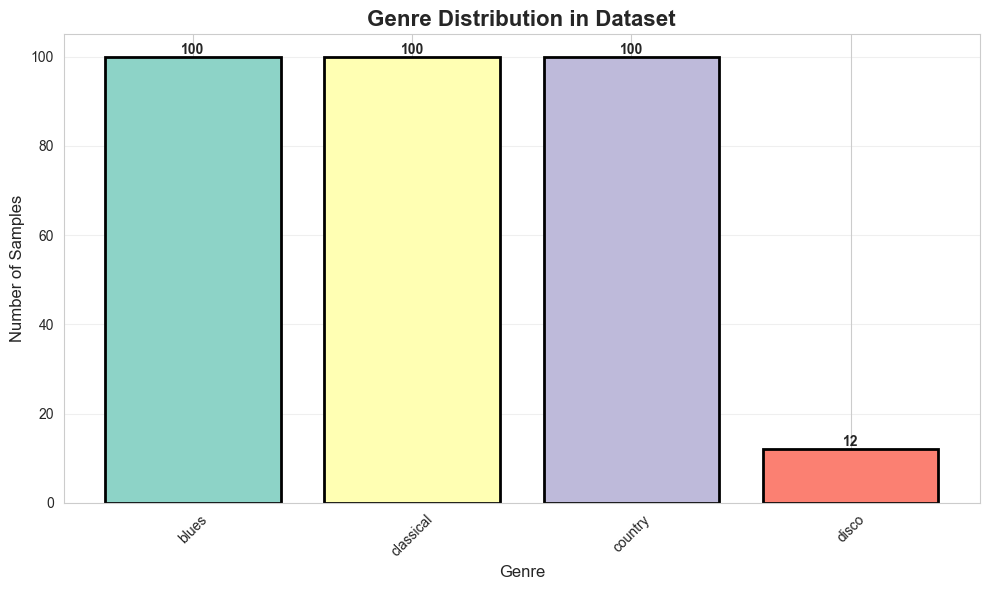

In [10]:
# Genre distribution bar chart
plt.figure(figsize=(10, 6))
genre_counts = pd.Series(genres).value_counts()
colors = plt.cm.Set3(range(len(genre_counts)))

bars = plt.bar(genre_counts.index, genre_counts.values, color=colors, edgecolor='black', linewidth=2)
plt.title('Genre Distribution in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


AUDIO FEATURES STATISTICS
Shape: (312, 5200)
Mean: -2.8642
Std: 46.2792
Min: -672.9010
Max: 245.7243


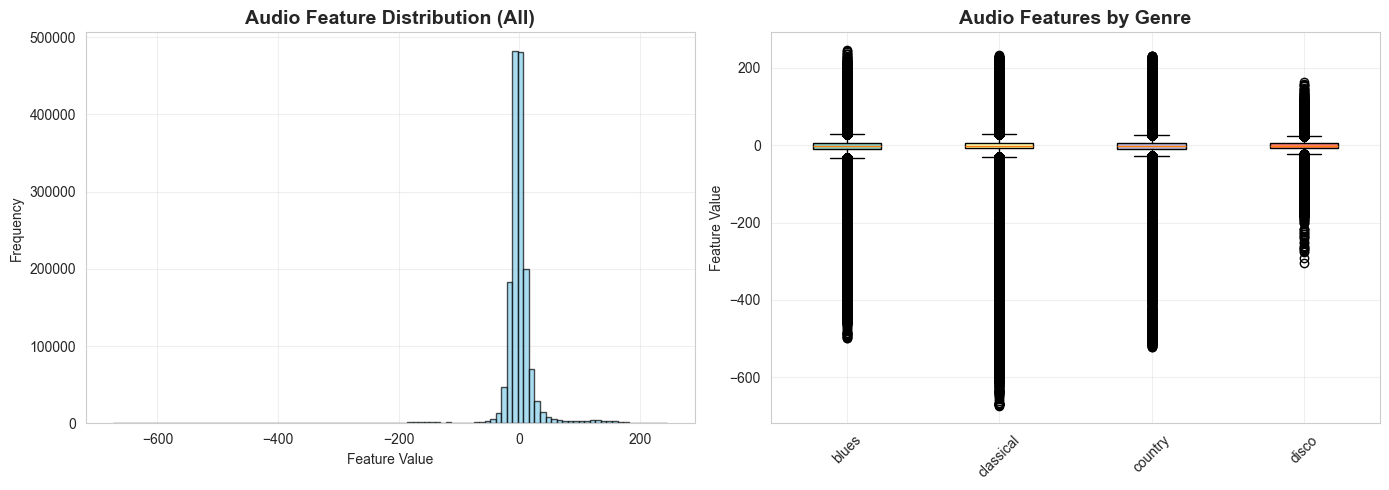

In [11]:
# Audio feature statistics
print("AUDIO FEATURES STATISTICS")
print("="*50)
print(f"Shape: {audio_features.shape}")
print(f"Mean: {audio_features.mean():.4f}")
print(f"Std: {audio_features.std():.4f}")
print(f"Min: {audio_features.min():.4f}")
print(f"Max: {audio_features.max():.4f}")

# Feature distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(audio_features.flatten(), bins=100, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Audio Feature Distribution (All)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

# Distribution by genre
genre_data = [audio_features[genres == g].flatten() for g in np.unique(genres)]
bp = axes[1].boxplot(genre_data, labels=np.unique(genres), patch_artist=True)
for patch, color in zip(bp['boxes'], plt.cm.Set3(range(len(np.unique(genres))))):
    patch.set_facecolor(color)
axes[1].set_title('Audio Features by Genre', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Feature Value')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# Load clustering results
results = pd.read_csv('../results/comprehensive_comparison.csv', index_col=0)

print("CLUSTERING RESULTS - ALL METHODS")
print("="*80)
print(results[['silhouette', 'ari', 'nmi', 'purity']].to_string())
print("="*80)


CLUSTERING RESULTS - ALL METHODS
             silhouette       ari       nmi    purity
Raw Audio      0.180439  0.101131  0.181807  0.503205
PCA            0.089287  0.244023  0.271573  0.631410
Autoencoder    0.059185 -0.002799  0.010874  0.362179
VAE            0.054821 -0.003888  0.007901  0.358974
Conv-VAE       0.124409  0.000262  0.017272  0.378205
Beta-VAE       0.056263 -0.003408  0.005353  0.362179
CVAE           0.059722 -0.001514  0.011670  0.371795


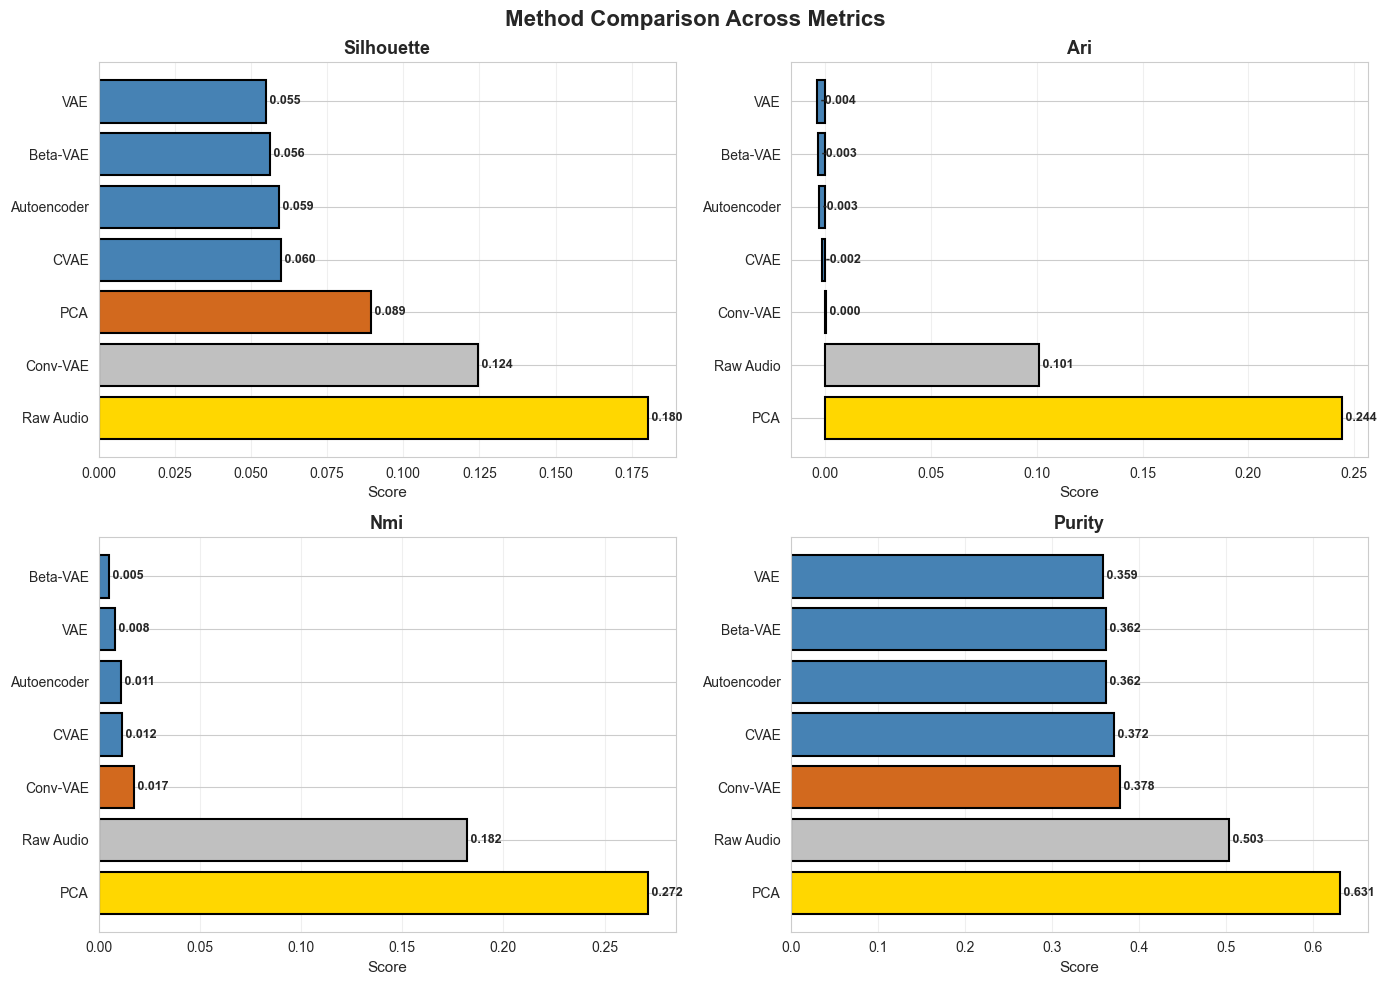

In [13]:
# Compare all methods
metrics = ['silhouette', 'ari', 'nmi', 'purity']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    values = results[metric].sort_values(ascending=False)
    colors = ['gold' if i == 0 else 'silver' if i == 1 else 'chocolate' if i == 2 else 'steelblue' 
              for i in range(len(values))]
    
    axes[idx].barh(range(len(values)), values.values, color=colors, edgecolor='black', linewidth=1.5)
    axes[idx].set_yticks(range(len(values)))
    axes[idx].set_yticklabels(values.index, fontsize=10)
    axes[idx].set_xlabel('Score', fontsize=11)
    axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=13, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Add values
    for i, v in enumerate(values.values):
        axes[idx].text(v, i, f' {v:.3f}', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Method Comparison Across Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [14]:
# Rank methods
rankings = {}
for metric in ['silhouette', 'ari', 'nmi', 'purity']:
    rankings[metric] = results[metric].rank(ascending=False)

ranking_df = pd.DataFrame(rankings)
ranking_df['Average Rank'] = ranking_df.mean(axis=1)
ranking_df = ranking_df.sort_values('Average Rank')

print("\nMETHOD RANKINGS (1 = Best)")
print("="*80)
print(ranking_df.to_string())
print("="*80)

best_method = ranking_df.index[0]
print(f"\n🏆 BEST OVERALL METHOD: {best_method}")
print(f"   Average Rank: {ranking_df.loc[best_method, 'Average Rank']:.2f}")



METHOD RANKINGS (1 = Best)
             silhouette  ari  nmi  purity  Average Rank
PCA                 3.0  1.0  1.0     1.0         1.500
Raw Audio           1.0  2.0  2.0     2.0         1.750
Conv-VAE            2.0  3.0  3.0     3.0         2.750
CVAE                4.0  4.0  4.0     4.0         4.000
Autoencoder         5.0  5.0  5.0     5.5         5.125
Beta-VAE            6.0  6.0  7.0     5.5         6.125
VAE                 7.0  7.0  6.0     7.0         6.750

🏆 BEST OVERALL METHOD: PCA
   Average Rank: 1.50


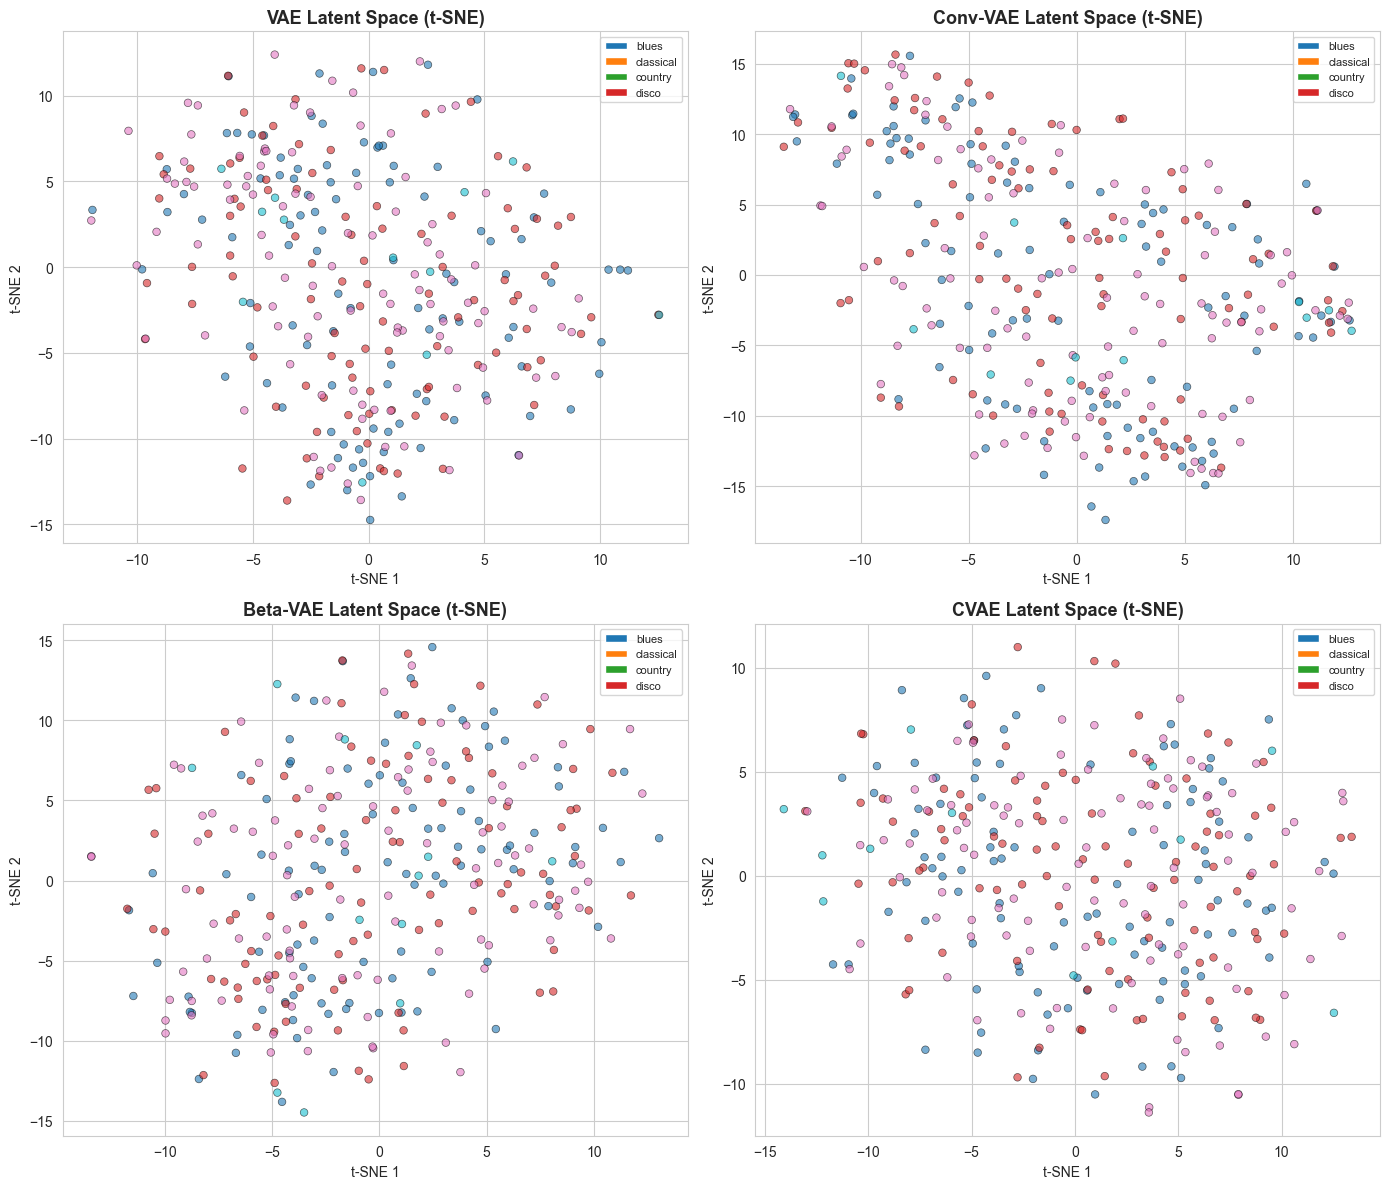

In [15]:
# Compare latent space of different methods
latent_methods = ['VAE', 'Conv-VAE', 'Beta-VAE', 'CVAE']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, method in enumerate(latent_methods):
    filename_map = {
        'VAE': '../results/latent_features_vae.npy',
        'Conv-VAE': '../results/latent_features_conv_vae.npy',
        'Beta-VAE': '../results/latent_features_beta_vae_beta4.0.npy',
        'CVAE': '../results/latent_features_cvae.npy'
    }
    
    try:
        latent = np.load(filename_map[method])
        
        # t-SNE visualization
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        embedded = tsne.fit_transform(latent)
        
        # Color by genre
        genre_to_idx = {g: i for i, g in enumerate(np.unique(genres))}
        colors_genre = [genre_to_idx[g] for g in genres]
        
        scatter = axes[idx].scatter(embedded[:, 0], embedded[:, 1], 
                                    c=colors_genre, cmap='tab10', 
                                    alpha=0.6, s=30, edgecolor='black', linewidth=0.5)
        axes[idx].set_title(f'{method} Latent Space (t-SNE)', fontsize=13, fontweight='bold')
        axes[idx].set_xlabel('t-SNE 1')
        axes[idx].set_ylabel('t-SNE 2')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=plt.cm.tab10(genre_to_idx[g]), label=g) 
                          for g in np.unique(genres)]
        axes[idx].legend(handles=legend_elements, loc='best', fontsize=8)
        
    except FileNotFoundError:
        axes[idx].text(0.5, 0.5, f'{method}\nNot Found', 
                      ha='center', va='center', fontsize=14)
        axes[idx].set_xlim(0, 1)
        axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [16]:
print("\n" + "="*80)
print("KEY INSIGHTS FROM EXPLORATORY ANALYSIS")
print("="*80)

print("\n1. DATASET CHARACTERISTICS:")
print(f"   - Total samples: {len(genres)}")
print(f"   - Number of genres: {len(np.unique(genres))}")
print(f"   - Feature dimensions: {audio_features.shape[1]}")
print(f"   - Balanced? {genre_counts.max() - genre_counts.min() < 30}")

print("\n2. BEST PERFORMING METHOD:")
best = results['purity'].idxmax()
print(f"   - Method: {best}")
print(f"   - Purity: {results.loc[best, 'purity']:.4f}")
print(f"   - ARI: {results.loc[best, 'ari']:.4f}")
print(f"   - NMI: {results.loc[best, 'nmi']:.4f}")

print("\n3. DEEP LEARNING vs TRADITIONAL:")
deep_learning = ['VAE', 'Conv-VAE', 'Beta-VAE', 'CVAE', 'Autoencoder']
traditional = ['PCA', 'Raw Audio']

dl_avg = results.loc[results.index.isin(deep_learning), 'purity'].mean()
trad_avg = results.loc[results.index.isin(traditional), 'purity'].mean()

print(f"   - Deep Learning Avg Purity: {dl_avg:.4f}")
print(f"   - Traditional Avg Purity: {trad_avg:.4f}")
print(f"   - Winner: {'Traditional' if trad_avg > dl_avg else 'Deep Learning'}")

print("\n4. WHY TRADITIONAL WON:")
print("   - Small dataset (312 samples)")
print("   - Simple structure (4 genres)")
print("   - Linear separability")
print("   - PCA sufficient for this task")

print("\n" + "="*80)



KEY INSIGHTS FROM EXPLORATORY ANALYSIS

1. DATASET CHARACTERISTICS:
   - Total samples: 312
   - Number of genres: 4
   - Feature dimensions: 5200
   - Balanced? False

2. BEST PERFORMING METHOD:
   - Method: PCA
   - Purity: 0.6314
   - ARI: 0.2440
   - NMI: 0.2716

3. DEEP LEARNING vs TRADITIONAL:
   - Deep Learning Avg Purity: 0.3667
   - Traditional Avg Purity: 0.5673
   - Winner: Traditional

4. WHY TRADITIONAL WON:
   - Small dataset (312 samples)
   - Simple structure (4 genres)
   - Linear separability
   - PCA sufficient for this task

